In [1]:
import os,sys,subprocess,glob,importlib,pickle,itertools
from datetime import datetime
import xarray as xr
import numpy as np
import pandas as pd
import scipy,math

sys.path.append('../../../REA_with_CESM2')
from ensembles.ensemble_GKLT import ensemble_GKLT,get_weight_for_selection

sys.path.append('../../')
from experiment_configuration.experiment import experiment
from experiment_configuration.regions.region_by_slice import create_or_load_regional_mask, regional_average, shift_lon


def import_from(module, name):
    module = __import__(module, fromlist=[name])
    return getattr(module, name)

%load_ext autoreload
%autoreload 2

In [2]:
exp = experiment(import_from(f'experiment_configuration.c1', 'config'), online=False)

In [3]:
initial_conditions = exp.initial_conditions

In [4]:
initial_condition_tags = [ini.split('/')[-2].split('.fE.')[0].split('.')[-1] + '_' + ini.split('/')[-1][:4] for ini in initial_conditions]

In [5]:
data_path = "/work/bb1152/u290372/cesm215_archive/GKLT/initial_ssp370-2025_05-31"

In [6]:
regional_mask = create_or_load_regional_mask(
    regional_mask_file = f"/work/bb1152/u290372/GKLT/regions/wEU.nc",
    slice_lat=slice(44,55), 
    slice_lon=slice(-4,12),
    )

def preprocessor(nc):
    nc = shift_lon(nc)
    obs = nc['SOILWATER_10CM'][0]
    obs = regional_average(obs, regional_mask)
    return obs

In [7]:
mrsos = []
for ini_name, ini_tag in zip(initial_conditions, initial_condition_tags):
    with xr.open_mfdataset(f"{data_path}/{ini_tag}/lnd/hist/{ini_tag}.clm2.h7.{ini_tag.split('_')[1]}-06-01-00000.nc", preprocess=preprocessor) as nc:
        mrsos.append(nc['SOILWATER_10CM'].load())

In [8]:
mrsos = xr.concat(mrsos, dim="sim")
mrsos = mrsos.assign_coords(sim = initial_conditions)

In [9]:
dry_selection = mrsos.sortby(mrsos)[:10]
dry_selection

<xarray.DataArray 'SOILWATER_10CM' (sim: 10)> Size: 40B
array([25.801521, 26.982443, 27.03402 , 27.183079, 28.235723, 28.288605,
       28.652754, 28.76875 , 28.921074, 29.00213 ], dtype=float32)
Coordinates:
    time     (sim) object 80B 2024-06-01 00:00:00 ... 2024-06-01 00:00:00
  * sim      (sim) <U151 6kB '/work/bb1445/u290372/cesm215_archive/BSSP370cmi...

In [10]:
dry_selection.sim.values

array(['/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens020.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.1200.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens009.fE.2020.ens000/2025-01-01_to_2025-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens016.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens018.fE.2020.ens000/2025-01-01_to_2025-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.1400.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP3

In [11]:
wet_selection = mrsos.sortby(mrsos)[-10:]
wet_selection

<xarray.DataArray 'SOILWATER_10CM' (sim: 10)> Size: 40B
array([35.961075, 35.97778 , 36.223106, 36.293488, 36.54776 , 36.629517,
       36.765785, 37.093307, 37.243725, 37.259926], dtype=float32)
Coordinates:
    time     (sim) object 80B 2024-06-01 00:00:00 ... 2025-06-01 00:00:00
  * sim      (sim) <U151 6kB '/work/bb1445/u290372/cesm215_archive/BSSP370cmi...

In [12]:
wet_selection.sim.values

array(['/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.1300.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens022.fE.2020.ens000/2025-01-01_to_2025-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens009.fE.2020.ens000/2026-01-01_to_2026-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens020.fE.2020.ens000/2025-01-01_to_2025-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens012.fE.2020.ens000/2025-01-01_to_2025-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens008.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_ar

(array([1., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
        1., 1., 2.]),
 array([25.8015213 , 25.96155167, 26.12158203, 26.2816124 , 26.44164276,
        26.60167313, 26.76170349, 26.92173386, 27.08176422, 27.24179459,
        27.40182495, 27.56185722, 27.72188759, 27.88191795, 28.04194832,
        28.20197868, 28.36200905, 28.52203941, 28.68206978, 28.84210014,
        29.00213051]),
 <BarContainer object of 20 artists>)

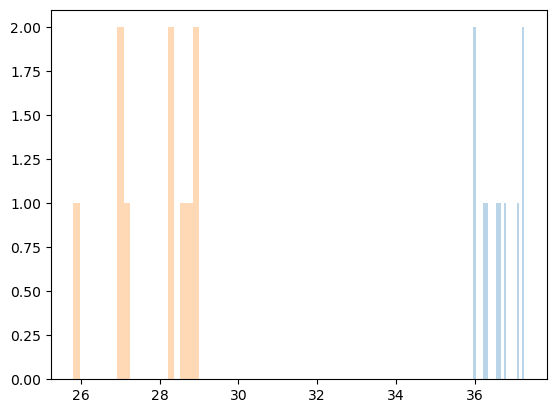

In [13]:
import matplotlib.pyplot as plt
plt.hist(wet_selection, bins=20, alpha=0.3)
plt.hist(dry_selection, bins=20, alpha=0.3)